## Import

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import json
import logging
import pathlib
from datetime import datetime

from graddft_qnn.helper.initialization import batched

import grad_dft as gd
import jax
import numpy as np
import pandas as pd
import pennylane as qml
import tqdm
import yaml
from jax import numpy as jnp
from jax.random import PRNGKey
from optax import adamw

from datasets import DatasetDict
from graddft_qnn import helper
from graddft_qnn.cube_dataset.h2_multibond import H2MultibondDataset
from graddft_qnn.dft_qnn import DFTQNN

# from graddft_qnn.helper import training
from graddft_qnn.io.ansatz_io import AnsatzIO
from graddft_qnn.naive_dft_qnn import NaiveDFTQNN
from graddft_qnn.qnn_functional import QNNFunctional
from graddft_qnn.unitary_rep import O_h, is_group

logging.getLogger().setLevel(logging.INFO)
np.random.seed(42)
key = PRNGKey(42)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
with open("config.yaml") as file:
    data = yaml.safe_load(file)
    num_qubits = data["GROUP"]["QBITS"]
    size = np.cbrt(2**num_qubits)
    assert size.is_integer()
    size = int(size)
    n_epochs = data["TRAINING"]["N_EPOCHS"]
    learning_rate = data["TRAINING"]["LEARNING_RATE"]
    momentum = data["TRAINING"]["MOMENTUM"]
    num_gates = data["N_GATES"]
    eval_per_x_epoch = data["TRAINING"]["EVAL_PER_X_EPOCH"]
    batch_size = data["TRAINING"]["BATCH_SIZE"]
    check_group = data["CHECK_GROUP"]
    flag_meanfield = data["FLAG_MEANFIELD"]
    assert (
        isinstance(num_gates, int) or num_gates == "full"
    ), f"N_GATES must be integer or 'full', got {num_gates}"
    full_measurements = "prob"
    group: list = data["GROUP"]
    group_str_rep = "]_[".join(group)[:230]
    if "naive" not in group["MEMBERS"]:
        group_matrix_reps = [getattr(O_h, gr)(size, False) for gr in group["MEMBERS"]]
        if (check_group) and (not is_group(group_matrix_reps, group)):
            raise ValueError("Not forming a group")
    xc_functional_name = data["XC_FUNCTIONAL"]
    dev = qml.device("default.qubit", wires=num_qubits)

In [4]:
filename = f"ansatz_{num_qubits}_{group_str_rep}_qubits"
layers = {0: [], 1: [], 2: []}

for wires in batched(range(0, 9), 3):
    layers[0].append(
        DFTQNN.gate_design(
            len(dev.wires),
            [
                getattr(O_h, gr)(size, True, starting_wire=wires[0])
                for gr in group["MEMBERS"]
            ],
            wires=wires,
        )[0]
    )

Creating invariant gates generator: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.67it/s]


In [5]:
layers[0]

[0.25 * (I(0) @ X(1) @ X(2) @ X(0) @ X(1) @ X(2) @ (Adjoint(I(0) @ X(1) @ X(2))) + X(0) @ I(1) @ X(2) @ X(0) @ X(1) @ X(2) @ (Adjoint(X(0) @ I(1) @ X(2))) + X(0) @ X(1) @ I(2) @ X(0) @ X(1) @ X(2) @ (Adjoint(X(0) @ X(1) @ I(2))) + (I(0) @ I(1)) @ I(2) @ X(0) @ X(1) @ X(2) @ (Adjoint((I(0) @ I(1)) @ I(2)))),
 0.25 * (I(3) @ X(4) @ X(5) @ X(3) @ X(4) @ X(5) @ (Adjoint(I(3) @ X(4) @ X(5))) + X(3) @ I(4) @ X(5) @ X(3) @ X(4) @ X(5) @ (Adjoint(X(3) @ I(4) @ X(5))) + X(0) @ X(1) @ X(2) @ X(3) @ X(4) @ I(5) @ X(3) @ X(4) @ X(5) @ (Adjoint(X(0) @ X(1) @ X(2) @ X(3) @ X(4) @ I(5))) + (I(3) @ I(4)) @ I(5) @ X(3) @ X(4) @ X(5) @ (Adjoint((I(3) @ I(4)) @ I(5)))),
 0.25 * (I(6) @ X(7) @ X(8) @ X(6) @ X(7) @ X(8) @ (Adjoint(I(6) @ X(7) @ X(8))) + X(6) @ I(7) @ X(8) @ X(6) @ X(7) @ X(8) @ (Adjoint(X(6) @ I(7) @ X(8))) + X(0) @ X(1) @ X(2) @ X(3) @ X(4) @ X(5) @ X(6) @ X(7) @ I(8) @ X(6) @ X(7) @ X(8) @ (Adjoint(X(0) @ X(1) @ X(2) @ X(3) @ X(4) @ X(5) @ X(6) @ X(7) @ I(8))) + (I(6) @ I(7)) @ I(8) @ X(

In [6]:
layer_1 = DFTQNN.gate_design(
    len(dev.wires),
    [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=3)],
    wires=[3, 4, 5],
)

Creating invariant gates generator: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.72it/s]


## Gates designing

Two points

1.
In the first layer of the EQCNN, equivariant convolutional and pooling layers can be built if $U_1$ (conv) and $V_1$ (pooling) commutes with all the possible three-qubit local group representations within $G$ which are

- 180 deg $x$ rotation: ${I \otimes I \otimes I, I \otimes I \otimes X, I \otimes X \otimes X, X \otimes X \otimes X}$
- 180 deg $y$ rotation: ${X \otimes I \otimes X, X \otimes X \otimes I, X \otimes I \otimes I, X \otimes X \otimes X}$
- 180 deg $z$ rotation: (shared with above) ${X \otimes X \otimes X, X \otimes X \otimes I, X \otimes I \otimes I, I \otimes I \otimes I}$


2. $U_1$ must statisfy the local (what is non-local) 2-design to prevent barren plateau

3. The paper Absence of Barren Plateaus in Quantum Convolutional Neural Networks only mentions "pool-based" QCNN that can avoid barren plateau. The math there is too scary for us to think about an analytical task about QCNN without pooling layer.

Next step:

- Try to think about repeating the network (Train 9 network, for 9 measurement to guarantee non-barren plateau and invariance). Note that we want 2^15 parameters, I don't want 
- Minh: Understand 2-design (t-design) and Haar distribution
- Minh thinks we could experiment with non-pooling QCNN just to see how the gradient goes. If we have good trainability, that should motivate a deeper analytic on non-pooling QCNN, which mean we only have local 2-design gates, how would that go. HK is not confident about the feasibility of this analytical task.
- HK continues to review Absence of Barren Plateaus in Quantum Convolutional Neural Networks

In [3]:
representations = (
    qml.I(0) @ qml.I(1) @ qml.X(2),
    qml.X(0) @ qml.X(1) @ qml.X(2),
    qml.X(0) @ qml.I(1) @ qml.X(2),
    qml.X(0) @ qml.X(1) @ qml.I(2),
    qml.X(0) @ qml.I(1) @ qml.I(2),
    qml.I(0) @ qml.X(1) @ qml.X(2),
)
for representation in tqdm.tqdm(representations):
    assert (
        qml.matrix(qml.commutator(qml.exp(-1j * layers[0][1]), representation)).max()
        < 1e-10
    )
    assert (
        qml.matrix(qml.commutator(qml.exp(-1j * layers[0][1]), representation)).min()
        > -1e-10
    )

NameError: name 'qml' is not defined

In [8]:
DFTQNN.gate_design(
    len(dev.wires),
    [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=wires[0])],
    wires=wires,
)[0]

Creating invariant gates generator: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 655.67it/s]


0.5 * (I(6) @ X(7) @ X(8) @ X(6) @ X(7) @ X(8) @ (Adjoint(I(6) @ X(7) @ X(8))) + (I(6) @ I(7)) @ I(8) @ X(6) @ X(7) @ X(8) @ (Adjoint((I(6) @ I(7)) @ I(8))))

In [9]:
DFTQNN.gate_design(
    len(dev.wires),
    [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=0)],
    wires=[0, 1, 2],
)[0]

Creating invariant gates generator: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 539.39it/s]


0.5 * (I(0) @ X(1) @ X(2) @ X(0) @ X(1) @ X(2) @ (Adjoint(I(0) @ X(1) @ X(2))) + (I(0) @ I(1)) @ I(2) @ X(0) @ X(1) @ X(2) @ (Adjoint((I(0) @ I(1)) @ I(2))))

Reflection and 180 deg x rotation group. Note that these are 2-wire gates

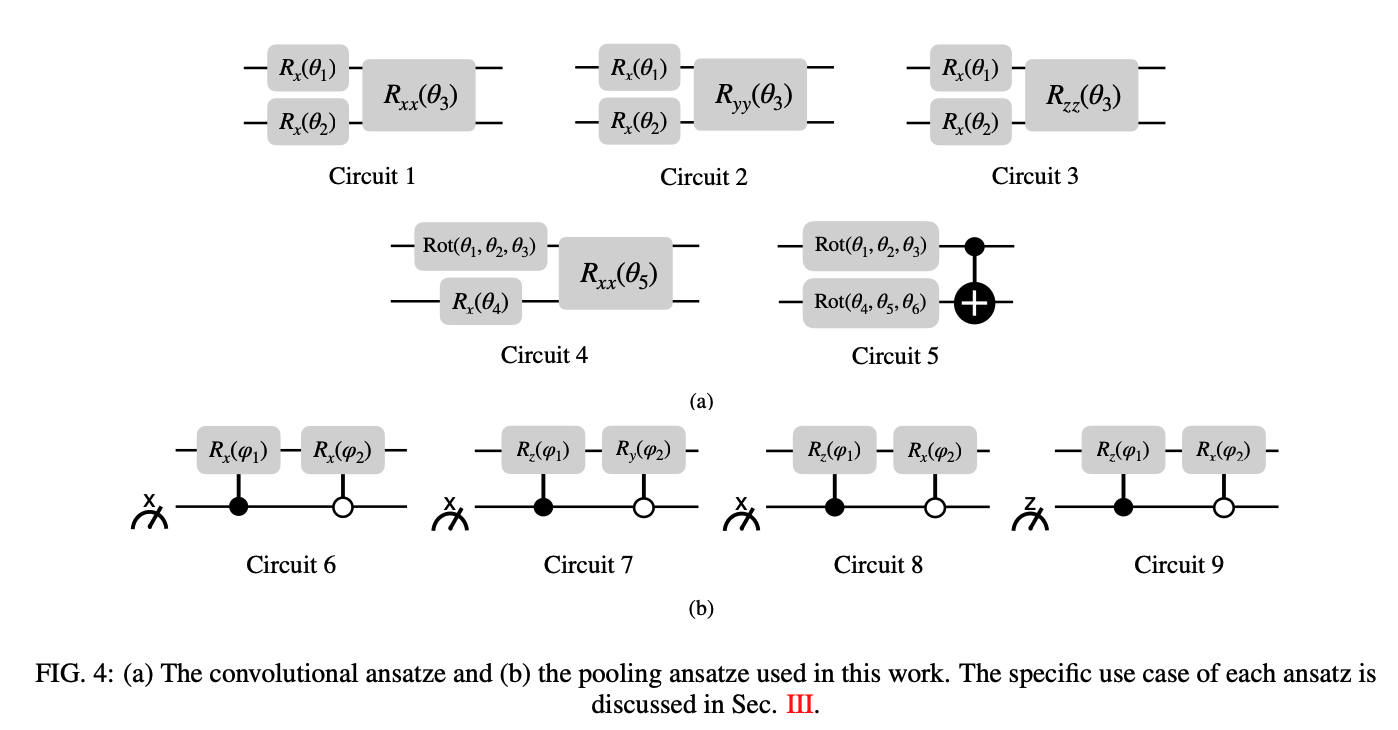

## Convolution

Creating invariant gates generator: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 628.17it/s]


(<Figure size 400x700 with 1 Axes>, <Axes: >)

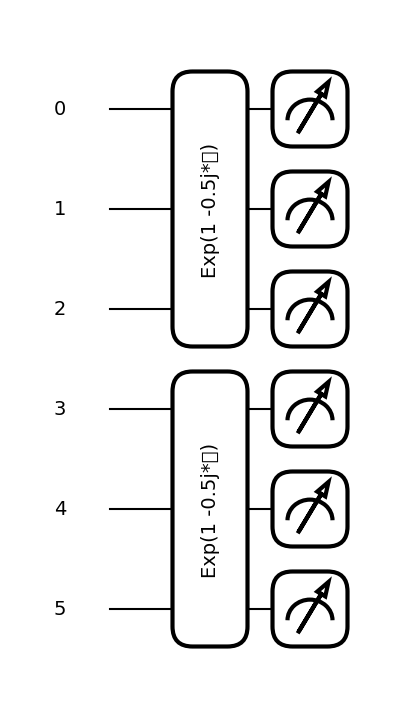

In [11]:
dev = qml.device("default.qubit", wires=6)


@qml.qnode(dev)
def circuit():
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=0)],
            wires=[0, 1, 2],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=3)],
            wires=[3, 4, 5],
        )[0]
    )
    return qml.probs()


qml.draw_mpl(circuit)()

## Pooling

In [12]:
def pool(control_wire, act_wires):
    base1 = qml.prod(*[qml.RX(0.5, wires=x) for x in act_wires])  # will be learnable
    controlled1 = qml.ops.op_math.Controlled(
        base1, control_wires=control_wire, control_values=True
    )
    base2 = qml.prod(*[qml.RX(0.5, wires=x) for x in act_wires])
    controlled2 = qml.ops.op_math.Controlled(
        base2, control_wires=control_wire, control_values=False
    )
    return controlled1, controlled2

(<Figure size 500x400 with 1 Axes>, <Axes: >)

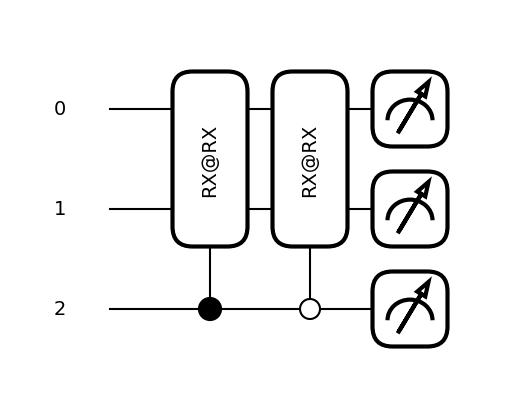

In [13]:
dev = qml.device("default.qubit", wires=3)


@qml.qnode(dev)
def circuit():
    pool(2, [0, 1])
    return qml.state()


qml.draw_mpl(circuit)()

In [14]:
representations = qml.I(0) @ qml.I(1) @ qml.X(2), qml.X(0) @ qml.X(1) @ qml.X(2)
c1, c2 = pool(2, [0, 1])
for representation in representations:
    assert qml.matrix(qml.commutator(c1 @ c2, representation)).max() < 1e-10
    assert qml.matrix(qml.commutator(c1 @ c2, representation)).min() > -1e-10

### Discuss pooling layer
- 1 or 2 output?
- $RX$ makes sense or not?

## Whole network

Creating invariant gates generator: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 264.98it/s]


(<Figure size 800x1400 with 1 Axes>, <Axes: >)

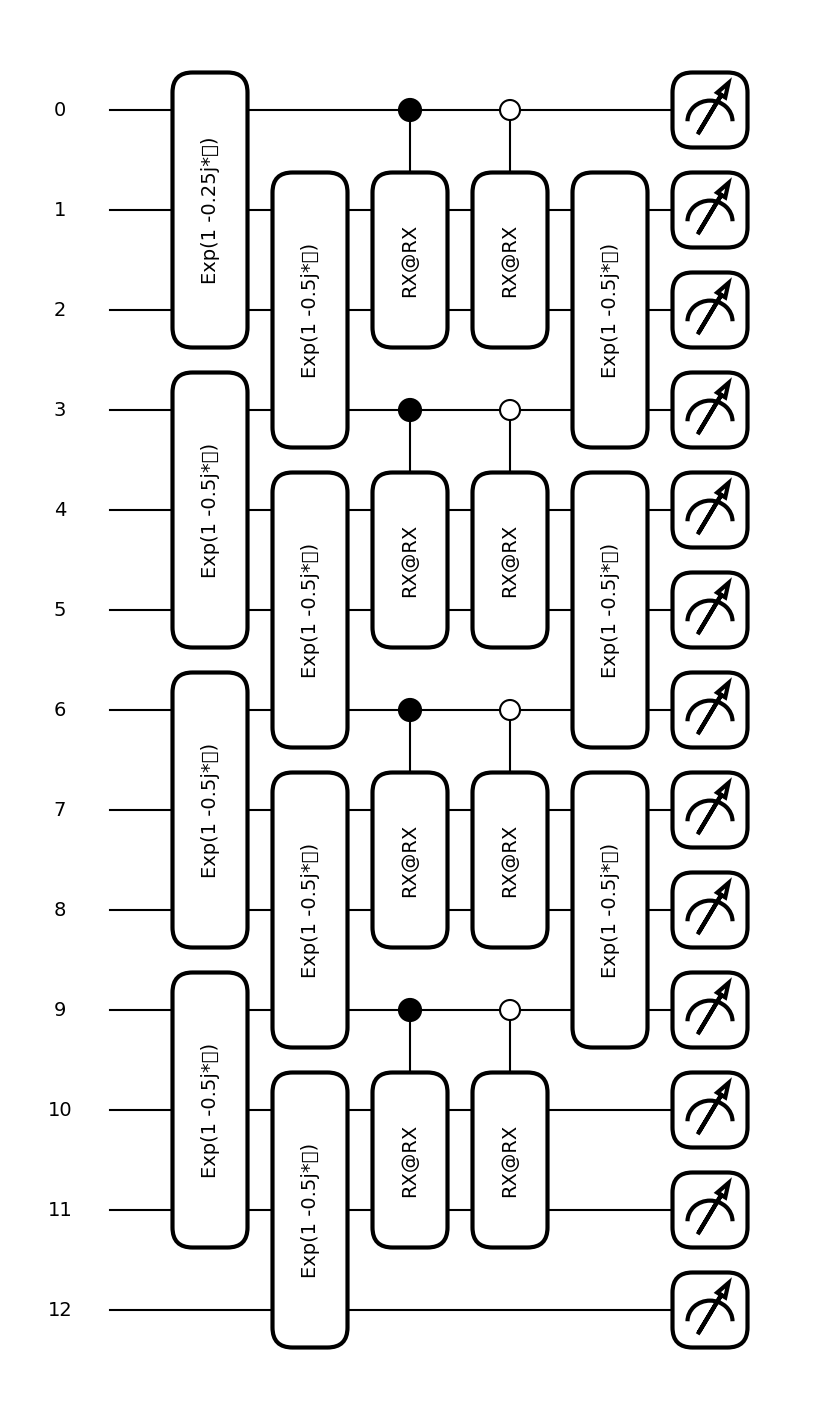

In [15]:
dev = qml.device("default.qubit", wires=12)


@qml.qnode(dev)
def circuit():
    # layer 1
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, gr)(size, True, starting_wire=0) for gr in group["MEMBERS"]],
            wires=[0, 1, 2],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=3)],
            wires=[3, 4, 5],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=6)],
            wires=[6, 7, 8],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=9)],
            wires=[9, 10, 11],
        )[0]
    )

    # layer 2
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=1)],
            wires=[1, 2, 3],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=4)],
            wires=[4, 5, 6],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=7)],
            wires=[7, 8, 9],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=10)],
            wires=[10, 11, 12],
        )[0]
    )

    # pool
    pool(0, [1, 2])
    pool(3, [4, 5])
    pool(6, [7, 8])
    pool(9, [10, 11])

    # layer 3
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][1])(size, True, starting_wire=1)],
            wires=[1, 2, 3],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][1])(size, True, starting_wire=4)],
            wires=[4, 5, 6],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][1])(size, True, starting_wire=7)],
            wires=[7, 8, 9],
        )[0]
    )

    # layer 4, to do change this to 180 z rotation

    return qml.probs()


qml.draw_mpl(circuit)()

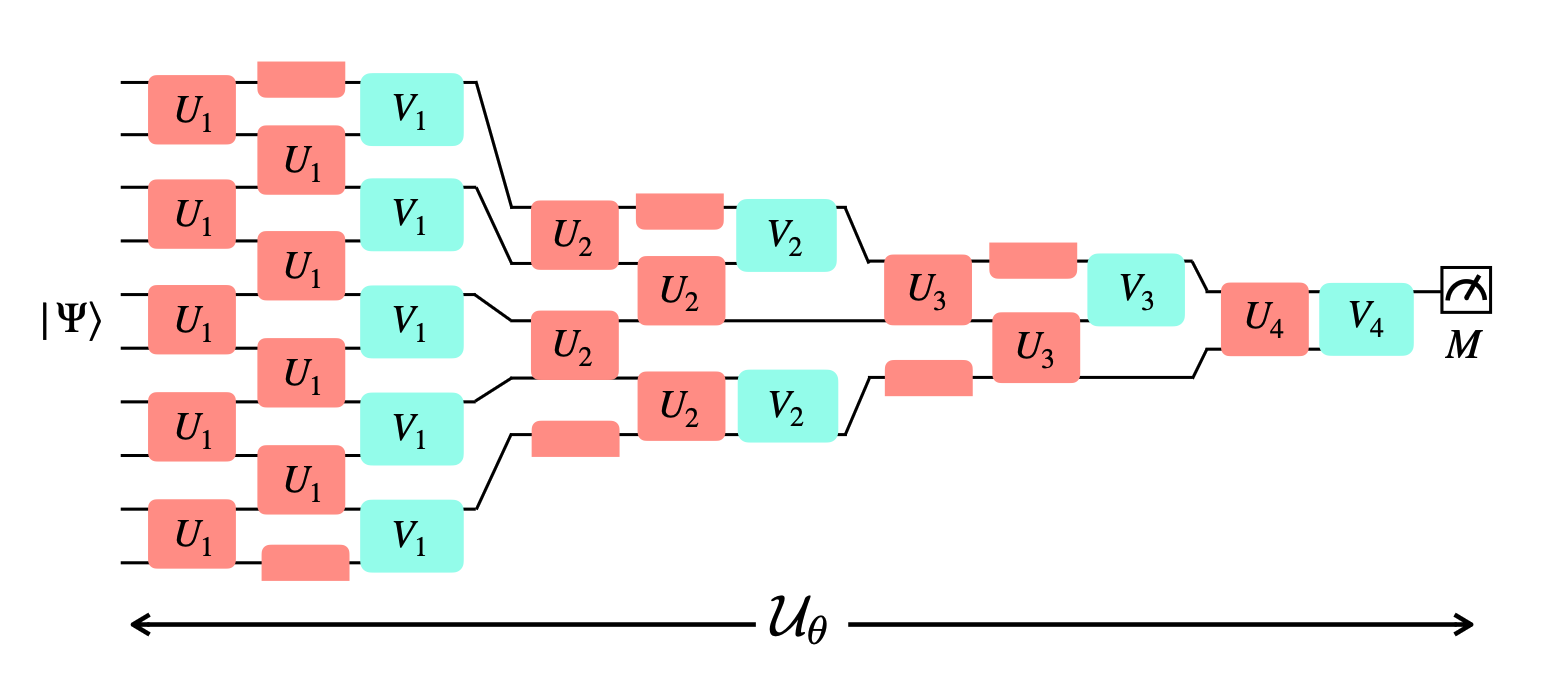

Todo:
- What does pooling to trainability.
- Google Generative quantum paper talks about this trainability too.

However, do note that: 
- in our QNN input and output have the same dimension (No pooling at all).
- the role of pooling for classic CNN is to save computational power
We may want to experience with something that still has the power of local kernel 

Creating invariant gates generator: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 664.81it/s]


(<Figure size 900x1300 with 1 Axes>, <Axes: >)

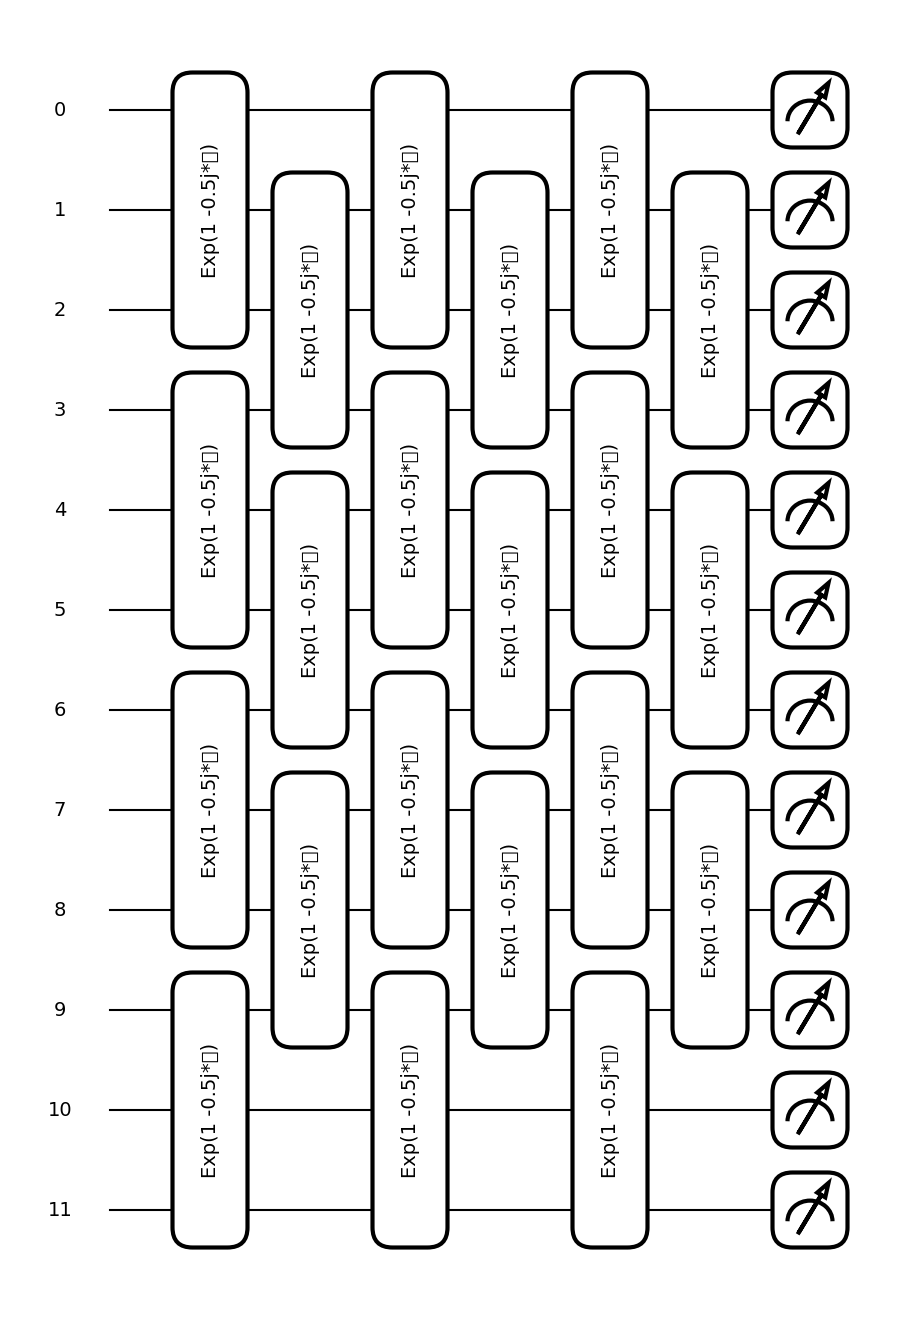

In [16]:
dev = qml.device("default.qubit", wires=12)


@qml.qnode(dev)
def circuit():
    # layer 1
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=0)],
            wires=[0, 1, 2],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=3)],
            wires=[3, 4, 5],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=6)],
            wires=[6, 7, 8],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=9)],
            wires=[9, 10, 11],
        )[0]
    )

    # layer 2
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=1)],
            wires=[1, 2, 3],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=4)],
            wires=[4, 5, 6],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=7)],
            wires=[7, 8, 9],
        )[0]
    )

    # ====================================

    # layer 3
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=0)],
            wires=[0, 1, 2],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=3)],
            wires=[3, 4, 5],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=6)],
            wires=[6, 7, 8],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=9)],
            wires=[9, 10, 11],
        )[0]
    )

    # layer 4
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=1)],
            wires=[1, 2, 3],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=4)],
            wires=[4, 5, 6],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=7)],
            wires=[7, 8, 9],
        )[0]
    )

    # ====================================
    # layer 5, to do change this to 180 z rotation
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=0)],
            wires=[0, 1, 2],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=3)],
            wires=[3, 4, 5],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=6)],
            wires=[6, 7, 8],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=9)],
            wires=[9, 10, 11],
        )[0]
    )

    # layer 4
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=1)],
            wires=[1, 2, 3],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=4)],
            wires=[4, 5, 6],
        )[0]
    )
    qml.exp(
        -1j
        * DFTQNN.gate_design(
            len(dev.wires),
            [getattr(O_h, group["MEMBERS"][0])(size, True, starting_wire=7)],
            wires=[7, 8, 9],
        )[0]
    )

    return qml.probs()


qml.draw_mpl(circuit)()